<a href="https://colab.research.google.com/github/NielsRogge/Transformers-Tutorials/blob/master/LayoutLMv3/Fine_tune_LayoutLMv3_on_FUNSD_(HuggingFace_Trainer).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Set-up environment

First, we install 🤗 Transformers, as well as 🤗 Datasets and Seqeval (the latter is useful for evaluation metrics such as F1 on sequence labeling tasks).

In [62]:
!pip install -q git+https://github.com/huggingface/transformers.git


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [61]:
!pip install -q datasets seqeval


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


## Load dataset

Next, we load a dataset from the 🤗 [hub](https://huggingface.co/datasets/nielsr/funsd-layoutlmv3). This one is the [FUNSD](https://guillaumejaume.github.io/FUNSD/) dataset, a collection of annotated forms.

In [63]:
import torch
from transformers import LayoutLMForTokenClassification, LayoutLMTokenizer
from torch.utils.data import DataLoader
from transformers import AdamW
from transformers import LayoutLMv2Processor
from PIL import Image

As we can see, the dataset consists of 2 splits ("train" and "test"), and each example contains a list of words ("tokens") with corresponding boxes ("bboxes"), and the words are tagged ("ner_tags"). Each example also include the original image ("image").

In [64]:
# from datasets import Features, Sequence, ClassLabel, Value

# # Define the features dictionary to match the required format
# features = Docbank_dataset.features



In [65]:
import os
import pandas as pd

# Directory containing CSV files
directory = "/Users/qanand/Documents/DocBank/DocBank_samples/Dataframes"

# Initialize lists to store all tokens, bounding boxes, and labels
all_tokens = []
all_bboxes = []
all_labels = []

# Process each CSV file in the directory
for filename in os.listdir(directory):
    if filename.endswith(".csv"):
        file_path = os.path.join(directory, filename)
        
        # Read CSV files into a DataFrame
        data = pd.read_csv(file_path)
        
        # Initialize lists to store tokens, bounding boxes, and labels for this file
        tokens = []
        bboxes = []
        labels = []
        
        # Iterate over each row in the DataFrame
        for _, row in data.iterrows():
            # Extract tokens, bounding boxes, and labels
            token = row['token']
            bbox = eval(row['bounding_box'])
            label = row['Label']
            
            # Append to the respective lists for this file
            tokens.append(token)
            bboxes.append(bbox)
            labels.append(label)
        
        # Append the lists for this file to the corresponding global lists
        all_tokens.append(tokens)
        all_bboxes.append(bboxes)
        all_labels.append(labels)

# Create a DataFrame from the combined lists
combined_data = pd.DataFrame({
    'tokens': all_tokens,
    'bounding_boxes': all_bboxes,
    'labels': all_labels
})

# Save the DataFrame to a new CSV file
# output_file_path = "combined_data.csv"
# combined_data.to_csv(output_file_path, index=False)


In [66]:
combined_data

tokens  \
0   [D, where, the, operator, is, deﬁned, as, (cid...   
1   [Algorithm, analysis, 4.1, Memory, requirement...   
2   [remark, on, the, Gaussian, lower, bound, for,...   
3   [estimate, the, covariance, matrix, over, a, l...   
4   [(cid:98), (cid:113), −, (cid:48), ≥, −, (1, δ...   
..                                                ...   
79  [LHC, 13, TeV, 550, 500, ], b, p, [, σ, 450, μ...   
80  [∝, V, =, V, +, V, ,, V, v, being, the, scalar...   
81  [in, Ref., [6],, let, us, consider, the, ﬁve-p...   
82  [j, Currently, at:, Center, for, Underground, ...   
83  [THE, AFFINITY, DIMENSION, 67, [32], Jenkinson...   

                                       bounding_boxes  \
0   [[252, 69, 265, 89], [107, 77, 150, 89], [155,...   
1   [[234, 117, 352, 136], [361, 117, 451, 136], [...   
2   [[166, 198, 291, 224], [305, 198, 347, 224], [...   
3   [[171, 103, 238, 116], [243, 103, 268, 116], [...   
4   [[383, 86, 392, 133], [520, 102, 537, 149], [3...   
..                                                ...   
79  [[359, 119, 381, 129], [384, 119, 395, 129], [...   
80  [[663, 58, 676, 80], [517, 68, 527, 80], [536,...   
81  [[133, 93, 149, 108], [156, 93, 189, 108], [19...   
82  [[175, 67, 180, 74], [187, 69, 249, 80], [254,...   
83  [[470, 121, 497, 130], [503, 121, 567, 130], [...   

                                               labels  
0   [paragraph, paragraph, paragraph, paragraph, p...  
1   [section, section, section, section, section, ...  
2   [title, title, title, title, title, title, tit...  
3   [paragraph, paragraph, paragraph, paragraph, p...  
4   [equation, equation, equation, equation, equat...  
..                                                ...  
79  [paragraph, paragraph, paragraph, paragraph, p...  
80  [paragraph, paragraph, paragraph, paragraph, p...  
81  [paragraph, paragraph, paragraph, paragraph, p...  
82  [author, author, author, author, author, autho...  
83  [paragraph, paragraph, paragraph, paragraph, r...  

[84 rows x 3 columns]

In [67]:
import os
import pandas as pd

# Directory containing CSV files
directory = "/Users/qanand/Documents/DocBank/DocBank_samples/Dataframes"

# Initialize lists to store all tokens, bounding boxes, labels, images, and IDs
all_tokens = []
all_bboxes = []
all_labels = []
all_images = []
all_ids = []

# Process each CSV file in the directory
for filename in os.listdir(directory):
    if filename.endswith(".csv"):
        file_path = os.path.join(directory, filename)
        
        # Read CSV files into a DataFrame
        data = pd.read_csv(file_path)
        
        # Initialize lists to store tokens, bounding boxes, labels, images, and IDs for this file
        tokens = []
        bboxes = []
        labels = []
        
        # Extract 'image' and 'id' columns from the DataFrame
        image = data.iloc[0]['image']
        _id = data.iloc[0]['id']
        
        # Iterate over each row in the DataFrame
        for _, row in data.iterrows():
            # Extract tokens, bounding boxes, and labels
            token = row['token']
            bbox = eval(row['bounding_box'])
            label = row['Label']
            
            # Append to the respective lists for this file
            tokens.append(token)
            bboxes.append(bbox)
            labels.append(label)
        
        # Append the lists for this file to the corresponding global lists
        all_tokens.append(tokens)
        all_bboxes.append(bboxes)
        all_labels.append(labels)
        all_images.append(image)
        all_ids.append(_id)

# Create a DataFrame from the combined lists
combined_data = pd.DataFrame({
    'tokens': all_tokens,
    'bounding_boxes': all_bboxes,
    'labels': all_labels,
    'image': all_images,
    'id': all_ids
})

# Save the DataFrame to a new CSV file
output_file_path = "combined_data.csv"
combined_data.to_csv(output_file_path, index=False)


In [132]:
combined_data

tokens  \
0   [D, where, the, operator, is, deﬁned, as, (cid...   
1   [Algorithm, analysis, 4.1, Memory, requirement...   
2   [remark, on, the, Gaussian, lower, bound, for,...   
3   [estimate, the, covariance, matrix, over, a, l...   
4   [(cid:98), (cid:113), −, (cid:48), ≥, −, (1, δ...   
..                                                ...   
79  [LHC, 13, TeV, 550, 500, ], b, p, [, σ, 450, μ...   
80  [∝, V, =, V, +, V, ,, V, v, being, the, scalar...   
81  [in, Ref., [6],, let, us, consider, the, ﬁve-p...   
82  [j, Currently, at:, Center, for, Underground, ...   
83  [THE, AFFINITY, DIMENSION, 67, [32], Jenkinson...   

                                       bounding_boxes  \
0   [[252, 69, 265, 89], [107, 77, 150, 89], [155,...   
1   [[234, 117, 352, 136], [361, 117, 451, 136], [...   
2   [[166, 198, 291, 224], [305, 198, 347, 224], [...   
3   [[171, 103, 238, 116], [243, 103, 268, 116], [...   
4   [[383, 86, 392, 133], [520, 102, 537, 149], [3...   
..                                                ...   
79  [[359, 119, 381, 129], [384, 119, 395, 129], [...   
80  [[663, 58, 676, 80], [517, 68, 527, 80], [536,...   
81  [[133, 93, 149, 108], [156, 93, 189, 108], [19...   
82  [[175, 67, 180, 74], [187, 69, 249, 80], [254,...   
83  [[470, 121, 497, 130], [503, 121, 567, 130], [...   

                                               labels  \
0   [paragraph, paragraph, paragraph, paragraph, p...   
1   [section, section, section, section, section, ...   
2   [title, title, title, title, title, title, tit...   
3   [paragraph, paragraph, paragraph, paragraph, p...   
4   [equation, equation, equation, equation, equat...   
..                                                ...   
79  [paragraph, paragraph, paragraph, paragraph, p...   
80  [paragraph, paragraph, paragraph, paragraph, p...   
81  [paragraph, paragraph, paragraph, paragraph, p...   
82  [author, author, author, author, author, autho...   
83  [paragraph, paragraph, paragraph, paragraph, r...   

                                                image   id  
0                141.tar_1410.7721.gz_arxiv_8_ori.jpg  141  
1         169.tar_1708.00745.gz_ODT_Soubies_8_ori.jpg  169  
2   40.tar_1503.04529.gz_GaussianLowerBounds_Lapla...   40  
3               7.tar_1801.02983.gz_Article_7_ori.jpg    7  
4   55.tar_1802.10418.gz_icml2018_songtao_arXiv_49...   55  
..                                                ...  ...  
79         211.tar_1611.00049.gz_NNLLpaper_14_ori.jpg  211  
80      171.tar_1510.07771.gz_manuscript_v1_5_ori.jpg  171  
81       65.tar_1803.03564.gz_faddeev271017_2_ori.jpg   65  
82     71.tar_1803.05570.gz_draft_eta_p_enu_2_ori.jpg   71  
83  212.tar_1807.09084.gz_pollicott-dimaff-arxiv_6...  212  

[84 rows x 5 columns]

In [133]:
import os

# Directory where your images are stored
image_directory = "/Users/qanand/Documents/DocBank/DocBank_samples/DocBank_samples/"

# Read the CSV file
df = pd.read_csv("combined_data.csv")

# Function to convert image filename to full file path
def filename_to_path(filename):
    return os.path.join(image_directory, filename)

# Convert image filenames to full file paths
df['image_path'] = df['image'].apply(filename_to_path)

# Display the DataFrame with image paths
print(df)


                                               tokens  \
0   ['D', 'where', 'the', 'operator', 'is', 'deﬁne...   
1   ['Algorithm', 'analysis', '4.1', 'Memory', 're...   
2   ['remark', 'on', 'the', 'Gaussian', 'lower', '...   
3   ['estimate', 'the', 'covariance', 'matrix', 'o...   
4   ['(cid:98)', '(cid:113)', '−', '(cid:48)', '≥'...   
..                                                ...   
79  ['LHC', '13', 'TeV', '550', '500', ']', 'b', '...   
80  ['∝', 'V', '=', 'V', '+', 'V', ',', 'V', 'v', ...   
81  ['in', 'Ref.', '[6],', 'let', 'us', 'consider'...   
82  ['j', 'Currently', 'at:', 'Center', 'for', 'Un...   
83  ['THE', 'AFFINITY', 'DIMENSION', '67', '[32]',...   

                                       bounding_boxes  \
0   [[252, 69, 265, 89], [107, 77, 150, 89], [155,...   
1   [[234, 117, 352, 136], [361, 117, 451, 136], [...   
2   [[166, 198, 291, 224], [305, 198, 347, 224], [...   
3   [[171, 103, 238, 116], [243, 103, 268, 116], [...   
4   [[383, 86, 392, 133], [520

In [134]:
df

tokens  \
0   ['D', 'where', 'the', 'operator', 'is', 'deﬁne...   
1   ['Algorithm', 'analysis', '4.1', 'Memory', 're...   
2   ['remark', 'on', 'the', 'Gaussian', 'lower', '...   
3   ['estimate', 'the', 'covariance', 'matrix', 'o...   
4   ['(cid:98)', '(cid:113)', '−', '(cid:48)', '≥'...   
..                                                ...   
79  ['LHC', '13', 'TeV', '550', '500', ']', 'b', '...   
80  ['∝', 'V', '=', 'V', '+', 'V', ',', 'V', 'v', ...   
81  ['in', 'Ref.', '[6],', 'let', 'us', 'consider'...   
82  ['j', 'Currently', 'at:', 'Center', 'for', 'Un...   
83  ['THE', 'AFFINITY', 'DIMENSION', '67', '[32]',...   

                                       bounding_boxes  \
0   [[252, 69, 265, 89], [107, 77, 150, 89], [155,...   
1   [[234, 117, 352, 136], [361, 117, 451, 136], [...   
2   [[166, 198, 291, 224], [305, 198, 347, 224], [...   
3   [[171, 103, 238, 116], [243, 103, 268, 116], [...   
4   [[383, 86, 392, 133], [520, 102, 537, 149], [3...   
..                                                ...   
79  [[359, 119, 381, 129], [384, 119, 395, 129], [...   
80  [[663, 58, 676, 80], [517, 68, 527, 80], [536,...   
81  [[133, 93, 149, 108], [156, 93, 189, 108], [19...   
82  [[175, 67, 180, 74], [187, 69, 249, 80], [254,...   
83  [[470, 121, 497, 130], [503, 121, 567, 130], [...   

                                               labels  \
0   ['paragraph', 'paragraph', 'paragraph', 'parag...   
1   ['section', 'section', 'section', 'section', '...   
2   ['title', 'title', 'title', 'title', 'title', ...   
3   ['paragraph', 'paragraph', 'paragraph', 'parag...   
4   ['equation', 'equation', 'equation', 'equation...   
..                                                ...   
79  ['paragraph', 'paragraph', 'paragraph', 'parag...   
80  ['paragraph', 'paragraph', 'paragraph', 'parag...   
81  ['paragraph', 'paragraph', 'paragraph', 'parag...   
82  ['author', 'author', 'author', 'author', 'auth...   
83  ['paragraph', 'paragraph', 'paragraph', 'parag...   

                                                image   id  \
0                141.tar_1410.7721.gz_arxiv_8_ori.jpg  141   
1         169.tar_1708.00745.gz_ODT_Soubies_8_ori.jpg  169   
2   40.tar_1503.04529.gz_GaussianLowerBounds_Lapla...   40   
3               7.tar_1801.02983.gz_Article_7_ori.jpg    7   
4   55.tar_1802.10418.gz_icml2018_songtao_arXiv_49...   55   
..                                                ...  ...   
79         211.tar_1611.00049.gz_NNLLpaper_14_ori.jpg  211   
80      171.tar_1510.07771.gz_manuscript_v1_5_ori.jpg  171   
81       65.tar_1803.03564.gz_faddeev271017_2_ori.jpg   65   
82     71.tar_1803.05570.gz_draft_eta_p_enu_2_ori.jpg   71   
83  212.tar_1807.09084.gz_pollicott-dimaff-arxiv_6...  212   

                                           image_path  
0   /Users/qanand/Documents/DocBank/DocBank_sample...  
1   /Users/qanand/Documents/DocBank/DocBank_sample...  
2   /Users/qanand/Documents/DocBank/DocBank_sample...  
3   /Users/qanand/Documents/DocBank/DocBank_sample...  
4   /Users/qanand/Documents/DocBank/DocBank_sample...  
..                                                ...  
79  /Users/qanand/Documents/DocBank/DocBank_sample...  
80  /Users/qanand/Documents/DocBank/DocBank_sample...  
81  /Users/qanand/Documents/DocBank/DocBank_sample...  
82  /Users/qanand/Documents/DocBank/DocBank_sample...  
83  /Users/qanand/Documents/DocBank/DocBank_sample...  

[84 rows x 6 columns]

In [135]:
import pandas as pd
from PIL import Image
import os

# Read the CSV file
# df = pd.read_csv("your_csv_file.csv")

# Function to convert JPEG image to PNG format
def jpeg_to_png(jpeg_path):
    try:
        # Load the JPEG image
        jpg_image = Image.open(jpeg_path)
        # Convert the image to PNG format
        png_path = jpeg_path.replace(".jpg", ".png")
        jpg_image.save(png_path)
        return png_path
    except Exception as e:
        print(f"Error converting image: {e}")
        return None

# Iterate through each image in the 'image' column and convert to PNG
df['png_image'] = df['image_path'].apply(jpeg_to_png)

# Drop rows where conversion failed
# df = df.dropna(subset=['png_image'])

# Save the modified DataFrame to a new CSV file
# df.to_csv("modified_csv_file.csv", index=False)


In [136]:
df

tokens  \
0   ['D', 'where', 'the', 'operator', 'is', 'deﬁne...   
1   ['Algorithm', 'analysis', '4.1', 'Memory', 're...   
2   ['remark', 'on', 'the', 'Gaussian', 'lower', '...   
3   ['estimate', 'the', 'covariance', 'matrix', 'o...   
4   ['(cid:98)', '(cid:113)', '−', '(cid:48)', '≥'...   
..                                                ...   
79  ['LHC', '13', 'TeV', '550', '500', ']', 'b', '...   
80  ['∝', 'V', '=', 'V', '+', 'V', ',', 'V', 'v', ...   
81  ['in', 'Ref.', '[6],', 'let', 'us', 'consider'...   
82  ['j', 'Currently', 'at:', 'Center', 'for', 'Un...   
83  ['THE', 'AFFINITY', 'DIMENSION', '67', '[32]',...   

                                       bounding_boxes  \
0   [[252, 69, 265, 89], [107, 77, 150, 89], [155,...   
1   [[234, 117, 352, 136], [361, 117, 451, 136], [...   
2   [[166, 198, 291, 224], [305, 198, 347, 224], [...   
3   [[171, 103, 238, 116], [243, 103, 268, 116], [...   
4   [[383, 86, 392, 133], [520, 102, 537, 149], [3...   
..                                                ...   
79  [[359, 119, 381, 129], [384, 119, 395, 129], [...   
80  [[663, 58, 676, 80], [517, 68, 527, 80], [536,...   
81  [[133, 93, 149, 108], [156, 93, 189, 108], [19...   
82  [[175, 67, 180, 74], [187, 69, 249, 80], [254,...   
83  [[470, 121, 497, 130], [503, 121, 567, 130], [...   

                                               labels  \
0   ['paragraph', 'paragraph', 'paragraph', 'parag...   
1   ['section', 'section', 'section', 'section', '...   
2   ['title', 'title', 'title', 'title', 'title', ...   
3   ['paragraph', 'paragraph', 'paragraph', 'parag...   
4   ['equation', 'equation', 'equation', 'equation...   
..                                                ...   
79  ['paragraph', 'paragraph', 'paragraph', 'parag...   
80  ['paragraph', 'paragraph', 'paragraph', 'parag...   
81  ['paragraph', 'paragraph', 'paragraph', 'parag...   
82  ['author', 'author', 'author', 'author', 'auth...   
83  ['paragraph', 'paragraph', 'paragraph', 'parag...   

                                                image   id  \
0                141.tar_1410.7721.gz_arxiv_8_ori.jpg  141   
1         169.tar_1708.00745.gz_ODT_Soubies_8_ori.jpg  169   
2   40.tar_1503.04529.gz_GaussianLowerBounds_Lapla...   40   
3               7.tar_1801.02983.gz_Article_7_ori.jpg    7   
4   55.tar_1802.10418.gz_icml2018_songtao_arXiv_49...   55   
..                                                ...  ...   
79         211.tar_1611.00049.gz_NNLLpaper_14_ori.jpg  211   
80      171.tar_1510.07771.gz_manuscript_v1_5_ori.jpg  171   
81       65.tar_1803.03564.gz_faddeev271017_2_ori.jpg   65   
82     71.tar_1803.05570.gz_draft_eta_p_enu_2_ori.jpg   71   
83  212.tar_1807.09084.gz_pollicott-dimaff-arxiv_6...  212   

                                           image_path  \
0   /Users/qanand/Documents/DocBank/DocBank_sample...   
1   /Users/qanand/Documents/DocBank/DocBank_sample...   
2   /Users/qanand/Documents/DocBank/DocBank_sample...   
3   /Users/qanand/Documents/DocBank/DocBank_sample...   
4   /Users/qanand/Documents/DocBank/DocBank_sample...   
..                                                ...   
79  /Users/qanand/Documents/DocBank/DocBank_sample...   
80  /Users/qanand/Documents/DocBank/DocBank_sample...   
81  /Users/qanand/Documents/DocBank/DocBank_sample...   
82  /Users/qanand/Documents/DocBank/DocBank_sample...   
83  /Users/qanand/Documents/DocBank/DocBank_sample...   

                                            png_image  
0   /Users/qanand/Documents/DocBank/DocBank_sample...  
1   /Users/qanand/Documents/DocBank/DocBank_sample...  
2   /Users/qanand/Documents/DocBank/DocBank_sample...  
3   /Users/qanand/Documents/DocBank/DocBank_sample...  
4   /Users/qanand/Documents/DocBank/DocBank_sample...  
..                                                ...  
79  /Users/qanand/Documents/DocBank/DocBank_sample...  
80  /Users/qanand/Documents/DocBank/DocBank_sample...  
81  /Users/qanand/Documents/DocBank/DocBank_sample...  
82

In [ ]:
# from PIL import Image
# import pandas as pd

# # Read the CSV file with image paths
# # df = pd.read_csv("your_csv_file.csv")

# # Function to load image from file path and convert to PNG format
# def load_and_convert_to_png(image_path):
#     try:
#         # Load the image
#         img = Image.open(image_path)
#         print(type(img))
#         # Convert to PNG format if needed
#         # if img.format != 'PNG':
#             # img = img.convert('RGB')
#         return img
#     except Exception as e:
#         print(f"Error loading or converting image: {e}")
#         return None

# # Convert image file paths to PIL images and store in 'image' column
# df['image'] = df['png_image'].apply(load_and_convert_to_png)

# # Display the DataFrame with PIL images
# # print(df)

# # Print the images
# for index, row in df.iterrows():
#     print("Image", index + 1)
#     display(row['image'])


In [73]:
df

tokens  \
0   ['D', 'where', 'the', 'operator', 'is', 'deﬁne...   
1   ['Algorithm', 'analysis', '4.1', 'Memory', 're...   
2   ['remark', 'on', 'the', 'Gaussian', 'lower', '...   
3   ['estimate', 'the', 'covariance', 'matrix', 'o...   
4   ['(cid:98)', '(cid:113)', '−', '(cid:48)', '≥'...   
..                                                ...   
79  ['LHC', '13', 'TeV', '550', '500', ']', 'b', '...   
80  ['∝', 'V', '=', 'V', '+', 'V', ',', 'V', 'v', ...   
81  ['in', 'Ref.', '[6],', 'let', 'us', 'consider'...   
82  ['j', 'Currently', 'at:', 'Center', 'for', 'Un...   
83  ['THE', 'AFFINITY', 'DIMENSION', '67', '[32]',...   

                                       bounding_boxes  \
0   [[252, 69, 265, 89], [107, 77, 150, 89], [155,...   
1   [[234, 117, 352, 136], [361, 117, 451, 136], [...   
2   [[166, 198, 291, 224], [305, 198, 347, 224], [...   
3   [[171, 103, 238, 116], [243, 103, 268, 116], [...   
4   [[383, 86, 392, 133], [520, 102, 537, 149], [3...   
..                                                ...   
79  [[359, 119, 381, 129], [384, 119, 395, 129], [...   
80  [[663, 58, 676, 80], [517, 68, 527, 80], [536,...   
81  [[133, 93, 149, 108], [156, 93, 189, 108], [19...   
82  [[175, 67, 180, 74], [187, 69, 249, 80], [254,...   
83  [[470, 121, 497, 130], [503, 121, 567, 130], [...   

                                               labels  \
0   ['paragraph', 'paragraph', 'paragraph', 'parag...   
1   ['section', 'section', 'section', 'section', '...   
2   ['title', 'title', 'title', 'title', 'title', ...   
3   ['paragraph', 'paragraph', 'paragraph', 'parag...   
4   ['equation', 'equation', 'equation', 'equation...   
..                                                ...   
79  ['paragraph', 'paragraph', 'paragraph', 'parag...   
80  ['paragraph', 'paragraph', 'paragraph', 'parag...   
81  ['paragraph', 'paragraph', 'paragraph', 'parag...   
82  ['author', 'author', 'author', 'author', 'auth...   
83  ['paragraph', 'paragraph', 'paragraph', 'parag...   

                                                image   id  \
0                141.tar_1410.7721.gz_arxiv_8_ori.jpg  141   
1         169.tar_1708.00745.gz_ODT_Soubies_8_ori.jpg  169   
2   40.tar_1503.04529.gz_GaussianLowerBounds_Lapla...   40   
3               7.tar_1801.02983.gz_Article_7_ori.jpg    7   
4   55.tar_1802.10418.gz_icml2018_songtao_arXiv_49...   55   
..                                                ...  ...   
79         211.tar_1611.00049.gz_NNLLpaper_14_ori.jpg  211   
80      171.tar_1510.07771.gz_manuscript_v1_5_ori.jpg  171   
81       65.tar_1803.03564.gz_faddeev271017_2_ori.jpg   65   
82     71.tar_1803.05570.gz_draft_eta_p_enu_2_ori.jpg   71   
83  212.tar_1807.09084.gz_pollicott-dimaff-arxiv_6...  212   

                                           image_path  \
0   /Users/qanand/Documents/DocBank/DocBank_sample...   
1   /Users/qanand/Documents/DocBank/DocBank_sample...   
2   /Users/qanand/Documents/DocBank/DocBank_sample...   
3   /Users/qanand/Documents/DocBank/DocBank_sample...   
4   /Users/qanand/Documents/DocBank/DocBank_sample...   
..                                                ...   
79  /Users/qanand/Documents/DocBank/DocBank_sample...   
80  /Users/qanand/Documents/DocBank/DocBank_sample...   
81  /Users/qanand/Documents/DocBank/DocBank_sample...   
82  /Users/qanand/Documents/DocBank/DocBank_sample...   
83  /Users/qanand/Documents/DocBank/DocBank_sample...   

                                            png_image  
0   /Users/qanand/Documents/DocBank/DocBank_sample...  
1   /Users/qanand/Documents/DocBank/DocBank_sample...  
2   /Users/qanand/Documents/DocBank/DocBank_sample...  
3   /Users/qanand/Documents/DocBank/DocBank_sample...  
4   /Users/qanand/Documents/DocBank/DocBank_sample...  
..                                                ...  
79  /Users/qanand/Documents/DocBank/DocBank_sample...  
80  /Users/qanand/Documents/DocBank/DocBank_sample...  
81  /Users/qanand/Documents/DocBank/DocBank_sample...  
82

In [137]:
# Drop the 'image_path' and 'image' columns
df.drop(['image_path', 'image'], axis=1, inplace=True)



In [138]:
df

tokens  \
0   ['D', 'where', 'the', 'operator', 'is', 'deﬁne...   
1   ['Algorithm', 'analysis', '4.1', 'Memory', 're...   
2   ['remark', 'on', 'the', 'Gaussian', 'lower', '...   
3   ['estimate', 'the', 'covariance', 'matrix', 'o...   
4   ['(cid:98)', '(cid:113)', '−', '(cid:48)', '≥'...   
..                                                ...   
79  ['LHC', '13', 'TeV', '550', '500', ']', 'b', '...   
80  ['∝', 'V', '=', 'V', '+', 'V', ',', 'V', 'v', ...   
81  ['in', 'Ref.', '[6],', 'let', 'us', 'consider'...   
82  ['j', 'Currently', 'at:', 'Center', 'for', 'Un...   
83  ['THE', 'AFFINITY', 'DIMENSION', '67', '[32]',...   

                                       bounding_boxes  \
0   [[252, 69, 265, 89], [107, 77, 150, 89], [155,...   
1   [[234, 117, 352, 136], [361, 117, 451, 136], [...   
2   [[166, 198, 291, 224], [305, 198, 347, 224], [...   
3   [[171, 103, 238, 116], [243, 103, 268, 116], [...   
4   [[383, 86, 392, 133], [520, 102, 537, 149], [3...   
..                                                ...   
79  [[359, 119, 381, 129], [384, 119, 395, 129], [...   
80  [[663, 58, 676, 80], [517, 68, 527, 80], [536,...   
81  [[133, 93, 149, 108], [156, 93, 189, 108], [19...   
82  [[175, 67, 180, 74], [187, 69, 249, 80], [254,...   
83  [[470, 121, 497, 130], [503, 121, 567, 130], [...   

                                               labels   id  \
0   ['paragraph', 'paragraph', 'paragraph', 'parag...  141   
1   ['section', 'section', 'section', 'section', '...  169   
2   ['title', 'title', 'title', 'title', 'title', ...   40   
3   ['paragraph', 'paragraph', 'paragraph', 'parag...    7   
4   ['equation', 'equation', 'equation', 'equation...   55   
..                                                ...  ...   
79  ['paragraph', 'paragraph', 'paragraph', 'parag...  211   
80  ['paragraph', 'paragraph', 'paragraph', 'parag...  171   
81  ['paragraph', 'paragraph', 'paragraph', 'parag...   65   
82  ['author', 'author', 'author', 'author', 'auth...   71   
83  ['paragraph', 'paragraph', 'paragraph', 'parag...  212   

                                            png_image  
0   /Users/qanand/Documents/DocBank/DocBank_sample...  
1   /Users/qanand/Documents/DocBank/DocBank_sample...  
2   /Users/qanand/Documents/DocBank/DocBank_sample...  
3   /Users/qanand/Documents/DocBank/DocBank_sample...  
4   /Users/qanand/Documents/DocBank/DocBank_sample...  
..                                                ...  
79  /Users/qanand/Documents/DocBank/DocBank_sample...  
80  /Users/qanand/Documents/DocBank/DocBank_sample...  
81  /Users/qanand/Documents/DocBank/DocBank_sample...  
82  /Users/qanand/Documents/DocBank/DocBank_sample...  
83  /Users/qanand/Documents/DocBank/DocBank_sample...  

[84 rows x 5 columns]

In [139]:
processor = LayoutLMv2Processor.from_pretrained("microsoft/layoutlmv2-base-uncased", revision="no_ocr")


In [140]:
def preprocess_data(examples):
  images = [Image.open("/Users/qanand/Documents/DocBank/DocBank_samples/combined_data.csv").convert("RGB") for path in examples['image']]
  
  words = examples['token']
  boxes = examples['bounding_box']
  word_labels = examples['Label']
  
  encoded_inputs = processor(images, words, boxes=boxes, word_labels=word_labels,
                             padding="max_length", truncation=True)
  
  return encoded_inputs

{'bboxes': Sequence(feature=Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), length=-1, id=None),
 'id': Value(dtype='string', id=None),
 'image': Image(decode=True, id=None),
 'ner_tags': Sequence(feature=ClassLabel(num_classes=7, names=['O', 'B-HEADER', 'I-HEADER', 'B-QUESTION', 'I-QUESTION', 'B-ANSWER', 'I-ANSWER'], id=None), length=-1, id=None),
 'tokens': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)}

abstract
author
caption
date
equation
figure
footer
list
paragraph
reference
section
table
title

Note that you can directly see the example in a notebook (as the "image" column is of type [Image](https://huggingface.co/docs/datasets/v2.2.1/en/package_reference/main_classes#datasets.Image)).

In [ ]:
# example = df
# example["image"]

## Prepare dataset

Next, we prepare the dataset for the model. This can be done very easily using `LayoutLMv3Processor`, which internally wraps a `LayoutLMv3FeatureExtractor` (for the image modality) and a `LayoutLMv3Tokenizer` (for the text modality) into one.

Basically, the processor does the following internally:
* the feature extractor is used to resize + normalize each document image into `pixel_values`
* the tokenizer is used to turn the words, boxes and NER tags into token-level `input_ids`, `attention_mask` and `labels`.

The processor simply returns a dictionary that contains all these keys.

In [78]:
from transformers import AutoProcessor

# we'll use the Auto API here - it will load LayoutLMv3Processor behind the scenes,
# based on the checkpoint we provide from the hub
processor = AutoProcessor.from_pretrained("microsoft/layoutlmv3-base", apply_ocr=False)

We'll first create `id2label` and label2id mappings, useful for inference. Note that `LayoutLMv3ForTokenClassification` (the model we'll use later on) will simply output an integer index for a particular class (for each token), so we still need to map it to an actual class name.

In [79]:
# Function to extract unique labels from a text file
def get_label_list_from_file(file_path):
    try:
        # Read the text file and extract labels
        with open(file_path, 'r') as file:
            labels = [line.strip() for line in file.readlines()]
            return labels
    except Exception as e:
        print(f"Error reading file or extracting labels: {e}")
        return []

# Path to your labels text file
labels_file_path = '/Users/qanand/Documents/DocBank/labels.txt'  # Replace 'labels.txt' with the actual path to your text file

# Extract unique labels from the text file
label_list = get_label_list_from_file(labels_file_path)

# Print the list of unique labels
print("Unique labels:", label_list)


Unique labels: ['abstract', 'author', 'caption', 'date', 'equation', 'figure', 'footer', 'list', 'paragraph', 'reference', 'section', 'table', 'title']


In [ ]:
#  Map labels to unique integers
label2id = {label: idx for idx, label in enumerate(label_list)}
id2label = {idx: label for idx, label in enumerate(label_list)}

# Example mapping for label columns in DataFrame
df[labels] = df[labels].apply(lambda labels: [label2id[label] for label in labels])

# Print label mappings
print("Label to ID mapping:")
print(label2id)
print("\nID to Label mapping:")
print(id2label)

KeyError: "None of [Index(['paragraph', 'paragraph', 'paragraph', 'paragraph', 'reference',\n       'reference', 'reference', 'reference', 'reference', 'reference',\n       ...\n       'reference', 'reference', 'reference', 'reference', 'reference',\n       'reference', 'reference', 'reference', 'reference', 'reference'],\n      dtype='object', length=593)] are in the [columns]"

In [126]:
from transformers import LayoutLMv3ForTokenClassification

model = LayoutLMv3ForTokenClassification.from_pretrained("microsoft/layoutlmv3-base",
                                                         id2label=id2label,
                                                         label2id=label2id)

Some weights of LayoutLMv3ForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlmv3-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [141]:
df

tokens  \
0   ['D', 'where', 'the', 'operator', 'is', 'deﬁne...   
1   ['Algorithm', 'analysis', '4.1', 'Memory', 're...   
2   ['remark', 'on', 'the', 'Gaussian', 'lower', '...   
3   ['estimate', 'the', 'covariance', 'matrix', 'o...   
4   ['(cid:98)', '(cid:113)', '−', '(cid:48)', '≥'...   
..                                                ...   
79  ['LHC', '13', 'TeV', '550', '500', ']', 'b', '...   
80  ['∝', 'V', '=', 'V', '+', 'V', ',', 'V', 'v', ...   
81  ['in', 'Ref.', '[6],', 'let', 'us', 'consider'...   
82  ['j', 'Currently', 'at:', 'Center', 'for', 'Un...   
83  ['THE', 'AFFINITY', 'DIMENSION', '67', '[32]',...   

                                       bounding_boxes  \
0   [[252, 69, 265, 89], [107, 77, 150, 89], [155,...   
1   [[234, 117, 352, 136], [361, 117, 451, 136], [...   
2   [[166, 198, 291, 224], [305, 198, 347, 224], [...   
3   [[171, 103, 238, 116], [243, 103, 268, 116], [...   
4   [[383, 86, 392, 133], [520, 102, 537, 149], [3...   
..                                                ...   
79  [[359, 119, 381, 129], [384, 119, 395, 129], [...   
80  [[663, 58, 676, 80], [517, 68, 527, 80], [536,...   
81  [[133, 93, 149, 108], [156, 93, 189, 108], [19...   
82  [[175, 67, 180, 74], [187, 69, 249, 80], [254,...   
83  [[470, 121, 497, 130], [503, 121, 567, 130], [...   

                                               labels   id  \
0   ['paragraph', 'paragraph', 'paragraph', 'parag...  141   
1   ['section', 'section', 'section', 'section', '...  169   
2   ['title', 'title', 'title', 'title', 'title', ...   40   
3   ['paragraph', 'paragraph', 'paragraph', 'parag...    7   
4   ['equation', 'equation', 'equation', 'equation...   55   
..                                                ...  ...   
79  ['paragraph', 'paragraph', 'paragraph', 'parag...  211   
80  ['paragraph', 'paragraph', 'paragraph', 'parag...  171   
81  ['paragraph', 'paragraph', 'paragraph', 'parag...   65   
82  ['author', 'author', 'author', 'author', 'auth...   71   
83  ['paragraph', 'paragraph', 'paragraph', 'parag...  212   

                                            png_image  
0   /Users/qanand/Documents/DocBank/DocBank_sample...  
1   /Users/qanand/Documents/DocBank/DocBank_sample...  
2   /Users/qanand/Documents/DocBank/DocBank_sample...  
3   /Users/qanand/Documents/DocBank/DocBank_sample...  
4   /Users/qanand/Documents/DocBank/DocBank_sample...  
..                                                ...  
79  /Users/qanand/Documents/DocBank/DocBank_sample...  
80  /Users/qanand/Documents/DocBank/DocBank_sample...  
81  /Users/qanand/Documents/DocBank/DocBank_sample...  
82  /Users/qanand/Documents/DocBank/DocBank_sample...  
83  /Users/qanand/Documents/DocBank/DocBank_sample...  

[84 rows x 5 columns]

In [ ]:
label2id

{'abstract': 0,
 'author': 1,
 'caption': 2,
 'date': 3,
 'equation': 4,
 'figure': 5,
 'footer': 6,
 'list': 7,
 'paragraph': 8,
 'reference': 9,
 'section': 10,
 'table': 11,
 'title': 12}

In [ ]:
label_list

['abstract',
 'author',
 'caption',
 'date',
 'equation',
 'figure',
 'footer',
 'list',
 'paragraph',
 'reference',
 'section',
 'table',
 'title']

In [ ]:
print(label_list)

['abstract', 'author', 'caption', 'date', 'equation', 'figure', 'footer', 'list', 'paragraph', 'reference', 'section', 'table', 'title']


In [ ]:
print(id2label)

{0: 'abstract', 1: 'author', 2: 'caption', 3: 'date', 4: 'equation', 5: 'figure', 6: 'footer', 7: 'list', 8: 'paragraph', 9: 'reference', 10: 'section', 11: 'table', 12: 'title'}


Next, we'll define a function which we can apply on the entire dataset.

In [85]:
import ast  # Importing ast module to parse the string representation of lists

# Convert the string representation of lists to actual lists
df['labels'] = df['labels'].apply(ast.literal_eval)

# Convert labels to IDs and create a new column 'labelid'
df['labels'] = df['labels'].apply(lambda labels: [label2id[label] for label in labels])

# Print the DataFrame with the new 'labelid' column
print(df)


ValueError: malformed node or string: ['paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'equation', 'equation', 'equation', 'equation', 'equation', 'equation', 'equation', 'equation', 'equation', 'equation', 'equation', 'equation', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'section', 'section', 'section', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'equation', 'equation', 'equation', 'equation', 'equation', 'equation', 'equation', 'equation', 'equation', 'equation', 'equation', 'equation', 'equation', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'equation', 'equation', 'equation', 'equation', 'equation', 'equation', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'section', 'section', 'section', 'section', 'section', 'section', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'equation', 'equation', 'equation', 'equation', 'equation', 'equation', 'equation', 'equation', 'equation', 'equation', 'equation', 'equation', 'equation', 'equation', 'equation', 'equation', 'equation', 'equation', 'equation', 'equation', 'equation', 'equation', 'equation', 'equation', 'equation', 'equation', 'equation', 'equation', 'equation', 'equation', 'equation', 'equation', 'equation', 'equation', 'equation', 'equation', 'equation', 'equation', 'equation', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'paragraph', 'equation', 'equation', 'equation', 'equation', 'equation', 'equation', 'equation', 'equation', 'equation', 'equation', 'equation', 'equation', 'equation', 'equation', 'equation', 'equation', 'equation', 'equation', 'equation', 'equation', 'equation', 'equation', 'equation', 'equation', 'equation', 'equation', 'equation', 'equation', 'equation', 'equation', 'equation', 'equation', 'equation', 'equation', 'equation', 'equation', 'equation', 'paragraph', 'paragraph', 'paragraph', 'equation', 'equation', 'equation']

In [142]:
df

tokens  \
0   ['D', 'where', 'the', 'operator', 'is', 'deﬁne...   
1   ['Algorithm', 'analysis', '4.1', 'Memory', 're...   
2   ['remark', 'on', 'the', 'Gaussian', 'lower', '...   
3   ['estimate', 'the', 'covariance', 'matrix', 'o...   
4   ['(cid:98)', '(cid:113)', '−', '(cid:48)', '≥'...   
..                                                ...   
79  ['LHC', '13', 'TeV', '550', '500', ']', 'b', '...   
80  ['∝', 'V', '=', 'V', '+', 'V', ',', 'V', 'v', ...   
81  ['in', 'Ref.', '[6],', 'let', 'us', 'consider'...   
82  ['j', 'Currently', 'at:', 'Center', 'for', 'Un...   
83  ['THE', 'AFFINITY', 'DIMENSION', '67', '[32]',...   

                                       bounding_boxes  \
0   [[252, 69, 265, 89], [107, 77, 150, 89], [155,...   
1   [[234, 117, 352, 136], [361, 117, 451, 136], [...   
2   [[166, 198, 291, 224], [305, 198, 347, 224], [...   
3   [[171, 103, 238, 116], [243, 103, 268, 116], [...   
4   [[383, 86, 392, 133], [520, 102, 537, 149], [3...   
..                                                ...   
79  [[359, 119, 381, 129], [384, 119, 395, 129], [...   
80  [[663, 58, 676, 80], [517, 68, 527, 80], [536,...   
81  [[133, 93, 149, 108], [156, 93, 189, 108], [19...   
82  [[175, 67, 180, 74], [187, 69, 249, 80], [254,...   
83  [[470, 121, 497, 130], [503, 121, 567, 130], [...   

                                               labels   id  \
0   ['paragraph', 'paragraph', 'paragraph', 'parag...  141   
1   ['section', 'section', 'section', 'section', '...  169   
2   ['title', 'title', 'title', 'title', 'title', ...   40   
3   ['paragraph', 'paragraph', 'paragraph', 'parag...    7   
4   ['equation', 'equation', 'equation', 'equation...   55   
..                                                ...  ...   
79  ['paragraph', 'paragraph', 'paragraph', 'parag...  211   
80  ['paragraph', 'paragraph', 'paragraph', 'parag...  171   
81  ['paragraph', 'paragraph', 'paragraph', 'parag...   65   
82  ['author', 'author', 'author', 'author', 'auth...   71   
83  ['paragraph', 'paragraph', 'paragraph', 'parag...  212   

                                            png_image  
0   /Users/qanand/Documents/DocBank/DocBank_sample...  
1   /Users/qanand/Documents/DocBank/DocBank_sample...  
2   /Users/qanand/Documents/DocBank/DocBank_sample...  
3   /Users/qanand/Documents/DocBank/DocBank_sample...  
4   /Users/qanand/Documents/DocBank/DocBank_sample...  
..                                                ...  
79  /Users/qanand/Documents/DocBank/DocBank_sample...  
80  /Users/qanand/Documents/DocBank/DocBank_sample...  
81  /Users/qanand/Documents/DocBank/DocBank_sample...  
82  /Users/qanand/Documents/DocBank/DocBank_sample...  
83  /Users/qanand/Documents/DocBank/DocBank_sample...  

[84 rows x 5 columns]

In [143]:
df.dtypes

tokens            object
bounding_boxes    object
labels            object
id                 int64
png_image         object
dtype: object

In [144]:
df.columns

Index(['tokens', 'bounding_boxes', 'labels', 'id', 'png_image'], dtype='object')

In [145]:
df.to_pickle("df")

In [147]:
from datasets import Dataset, Image

# Example DataFrame
# df = pd.read_csv("your_dataframe.csv")

# Convert DataFrame to a Dataset
dataset = Dataset.from_pandas(df).cast_column("png_image", Image())

# Cast the image path column to the Image type
# dataset = dataset.cast_column("image", Image())

# Now the dataset contains all the image paths from your DataFrame


In [148]:
dataset['png_image']

[<PIL.PngImagePlugin.PngImageFile image mode=RGB size=1654x2339>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGB size=1700x2200>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGB size=1221x1851>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGB size=1700x2200>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGB size=1700x2200>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGB size=1700x2200>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGB size=1654x2339>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGB size=1700x2200>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGB size=1700x2200>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGB size=1700x2200>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGB size=1700x2200>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGB size=1654x2339>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGB size=1700x2200>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGB size=1700x2200>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGB size=1700x2200>,
 <PIL.PngI

In [149]:
dataset

Dataset({
    features: ['tokens', 'bounding_boxes', 'labels', 'id', 'png_image'],
    num_rows: 84
})

In [150]:
from datasets import load_dataset, Image

# Load the dataset and cast the image column to the Image type
# dataset = load_dataset("dataset", split="train").cast_column("image", Image(decode=False))

# Iterate over each example in the dataset
for example in dataset:
    # Access the image path
    image_path = example["png_image"]
    
    # Perform further processing with the image path
    print(image_path)


<PIL.PngImagePlugin.PngImageFile image mode=RGB size=1654x2339 at 0x181C6D5B0>
<PIL.PngImagePlugin.PngImageFile image mode=RGB size=1700x2200 at 0x181C6ECF0>
<PIL.PngImagePlugin.PngImageFile image mode=RGB size=1221x1851 at 0x181C6CC50>
<PIL.PngImagePlugin.PngImageFile image mode=RGB size=1700x2200 at 0x181C6CB60>
<PIL.PngImagePlugin.PngImageFile image mode=RGB size=1700x2200 at 0x181C6E8D0>
<PIL.PngImagePlugin.PngImageFile image mode=RGB size=1700x2200 at 0x181C6DCD0>
<PIL.PngImagePlugin.PngImageFile image mode=RGB size=1654x2339 at 0x181C6DC70>
<PIL.PngImagePlugin.PngImageFile image mode=RGB size=1700x2200 at 0x181C6CCE0>
<PIL.PngImagePlugin.PngImageFile image mode=RGB size=1700x2200 at 0x181C6CBF0>
<PIL.PngImagePlugin.PngImageFile image mode=RGB size=1700x2200 at 0x181C6ECF0>
<PIL.PngImagePlugin.PngImageFile image mode=RGB size=1700x2200 at 0x181C6E2A0>
<PIL.PngImagePlugin.PngImageFile image mode=RGB size=1654x2339 at 0x181C6F770>
<PIL.PngImagePlugin.PngImageFile image mode=RGB size

In [151]:
dataset

Dataset({
    features: ['tokens', 'bounding_boxes', 'labels', 'id', 'png_image'],
    num_rows: 84
})

In [152]:
def prepare_examples(examples):
    # print(examples["tokens"])
  images = examples["png_image"]
  words = examples["tokens"]
  boxes = examples["bounding_boxes"]
  word_labels = examples["labels"]

  encoding = processor(images, words, boxes=boxes, word_labels=word_labels,
                       truncation=True, padding="max_length")

  return encoding

In [153]:
dataset.features

{'tokens': Value(dtype='string', id=None),
 'bounding_boxes': Value(dtype='string', id=None),
 'labels': Value(dtype='string', id=None),
 'id': Value(dtype='int64', id=None),
 'png_image': Image(decode=True, id=None)}

In [ ]:
# # Print the values in the 'bounding_boxes' and 'labels' columns
# print("Bounding Boxes:")
# for value in df['bounding_boxes']:
#     print(value)

# print("\nLabels:")
# for value in df['labels']:
#     print(value)


In [154]:
docbank_df=pd.read_pickle("/Users/qanand/Documents/DocBank/DocBank_samples/df")

In [155]:
for index, row in docbank_df[:1].iterrows():
    print(type(row['bounding_boxes']))
    print(type(row['tokens']))
    print(type(row['labels']))
    print(type(row['id']))
    print(type(row['png_image']))


<class 'str'>
<class 'str'>
<class 'str'>
<class 'int'>
<class 'str'>


In [156]:
import ast

rows_to_drop = []

for index, row in docbank_df.iterrows():
    try:
        bounding_boxes = ast.literal_eval(row['bounding_boxes'])
        tokens = ast.literal_eval(row['tokens'])
        labels = ast.literal_eval(row['labels'])
        id_value = row['id']
        png_image = row['png_image']
        
        docbank_df.at[index, 'bounding_boxes'] = bounding_boxes
        docbank_df.at[index, 'tokens'] = tokens
        docbank_df.at[index, 'labels'] = labels
        docbank_df.at[index, 'id'] = id_value
        docbank_df.at[index, 'png_image'] = png_image
        
    except Exception as e:
        print("Error occurred in row", index, ":", e)
        rows_to_drop.append(index)

docbank_df.drop(index=rows_to_drop, inplace=True)

Error occurred in row 14 : malformed node or string on line 1: <ast.Name object at 0x182ef6f90>
Error occurred in row 19 : malformed node or string on line 1: <ast.Name object at 0x18262e890>
Error occurred in row 30 : malformed node or string on line 1: <ast.Name object at 0x182449750>


In [157]:
type(dataset["bounding_boxes"][0])

str

{'bboxes': Sequence(feature=Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), length=-1, id=None),
 'id': Value(dtype='string', id=None),
 'image': Image(decode=True, id=None),
 'ner_tags': Sequence(feature=ClassLabel(num_classes=7, names=['O', 'B-HEADER', 'I-HEADER', 'B-QUESTION', 'I-QUESTION', 'B-ANSWER', 'I-ANSWER'], id=None), length=-1, id=None),
 'tokens': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)}

In [182]:
from datasets import Dataset, Image

# Example DataFrame
# df = pd.read_csv("your_dataframe.csv")

# Convert DataFrame to a Dataset
Docbank_dataset = Dataset.from_pandas(docbank_df).cast_column("png_image", Image())

In [183]:
Docbank_dataset

Dataset({
    features: ['tokens', 'bounding_boxes', 'labels', 'id', 'png_image', '__index_level_0__'],
    num_rows: 81
})

In [160]:
docbank_df.columns

Index(['tokens', 'bounding_boxes', 'labels', 'id', 'png_image'], dtype='object')

In [161]:
Docbank_dataset.features

{'tokens': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
 'bounding_boxes': Sequence(feature=Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), length=-1, id=None),
 'labels': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
 'id': Value(dtype='int64', id=None),
 'png_image': Image(decode=True, id=None),
 '__index_level_0__': Value(dtype='int64', id=None)}

{'bboxes': Sequence(feature=Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), length=-1, id=None),
 'id': Value(dtype='string', id=None),
 'image': Image(decode=True, id=None),
 'ner_tags': Sequence(feature=ClassLabel(num_classes=7, names=['O', 'B-HEADER', 'I-HEADER', 'B-QUESTION', 'I-QUESTION', 'B-ANSWER', 'I-ANSWER'], id=None), length=-1, id=None),
 'tokens': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)}

In [176]:

from datasets.features import ClassLabel

features = Docbank_dataset.features
column_names = Docbank_dataset.column_names
image_column_name = "png_image"
text_column_name = "tokens"
boxes_column_name = "bounding_boxes"
label_column_name = "labels"

# In the event the labels are not a `Sequence[ClassLabel]`, we will need to go through the dataset to get the
# unique labels.
def get_label_list(labels):
    unique_labels = set()
    for label in labels:
        unique_labels = unique_labels | set(label)
    label_list = list(unique_labels)
    label_list.sort()
    return label_list

if isinstance(features[label_column_name].feature, ClassLabel):
    label_list = features[label_column_name].feature.names
    # No need to convert the labels since they are already ints.
    id2label = {k: v for k,v in enumerate(label_list)}
    label2id = {v: k for k,v in enumerate(label_list)}
else:
    label_list = get_label_list(Docbank_dataset[label_column_name])
    id2label = {k: v for k,v in enumerate(label_list)}
    label2id = {v: k for k,v in enumerate(label_list)}
num_labels = len(label_list)

In [178]:
label2id

{'abstract': 0,
 'author': 1,
 'caption': 2,
 'date': 3,
 'equation': 4,
 'figure': 5,
 'footer': 6,
 'list': 7,
 'paragraph': 8,
 'reference': 9,
 'section': 10,
 'table': 11,
 'title': 12}

In [186]:
# Convert the string representation of lists to actual lists
# docbank_df['labels'] = docbank_df['labels'].apply(ast.literal_eval)
# Example mapping for label columns in DataFrame
docbank_df["labels"] = docbank_df["labels"].apply(lambda labels: [label2id[label] for label in labels])

KeyError: 8

In [180]:
docbank_df

tokens  \
0   [D, where, the, operator, is, deﬁned, as, (cid...   
1   [Algorithm, analysis, 4.1, Memory, requirement...   
2   [remark, on, the, Gaussian, lower, bound, for,...   
3   [estimate, the, covariance, matrix, over, a, l...   
4   [(cid:98), (cid:113), −, (cid:48), ≥, −, (1, δ...   
..                                                ...   
79  [LHC, 13, TeV, 550, 500, ], b, p, [, σ, 450, μ...   
80  [∝, V, =, V, +, V, ,, V, v, being, the, scalar...   
81  [in, Ref., [6],, let, us, consider, the, ﬁve-p...   
82  [j, Currently, at:, Center, for, Underground, ...   
83  [THE, AFFINITY, DIMENSION, 67, [32], Jenkinson...   

                                       bounding_boxes  \
0   [[252, 69, 265, 89], [107, 77, 150, 89], [155,...   
1   [[234, 117, 352, 136], [361, 117, 451, 136], [...   
2   [[166, 198, 291, 224], [305, 198, 347, 224], [...   
3   [[171, 103, 238, 116], [243, 103, 268, 116], [...   
4   [[383, 86, 392, 133], [520, 102, 537, 149], [3...   
..                                                ...   
79  [[359, 119, 381, 129], [384, 119, 395, 129], [...   
80  [[663, 58, 676, 80], [517, 68, 527, 80], [536,...   
81  [[133, 93, 149, 108], [156, 93, 189, 108], [19...   
82  [[175, 67, 180, 74], [187, 69, 249, 80], [254,...   
83  [[470, 121, 497, 130], [503, 121, 567, 130], [...   

                                               labels   id  \
0   [8, 8, 8, 8, 8, 8, 8, 4, 4, 4, 4, 4, 4, 4, 4, ...  141   
1   [10, 10, 10, 10, 10, 8, 8, 8, 8, 8, 8, 8, 8, 8...  169   
2   [12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 1...   40   
3   [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, ...    7   
4   [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ...   55   
..                                                ...  ...   
79  [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, ...  211   
80  [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, ...  171   
81  [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 4, ...   65   
82  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 8, ...   71   
83  [8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, ...  212   

                                            png_image  
0   /Users/qanand/Documents/DocBank/DocBank_sample...  
1   /Users/qanand/Documents/DocBank/DocBank_sample...  
2   /Users/qanand/Documents/DocBank/DocBank_sample...  
3   /Users/qanand/Documents/DocBank/DocBank_sample...  
4   /Users/qanand/Documents/DocBank/DocBank_sample...  
..                                                ...  
79  /Users/qanand/Documents/DocBank/DocBank_sample...  
80  /Users/qanand/Documents/DocBank/DocBank_sample...  
81  /Users/qanand/Documents/DocBank/DocBank_sample...  
82  /Users/qanand/Documents/DocBank/DocBank_sample...  
83  /Users/qanand/Documents/DocBank/DocBank_sample...  

[81 rows x 5 columns]

In [187]:
from datasets import Dataset, Image

# Example DataFrame
# df = pd.read_csv("your_dataframe.csv")

# Convert DataFrame to a Dataset
Docbank_dataset = Dataset.from_pandas(docbank_df).cast_column("png_image", Image())

In [188]:
Docbank_dataset.features

{'tokens': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
 'bounding_boxes': Sequence(feature=Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), length=-1, id=None),
 'labels': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None),
 'id': Value(dtype='int64', id=None),
 'png_image': Image(decode=True, id=None),
 '__index_level_0__': Value(dtype='int64', id=None)}

In [190]:
from datasets import Features, Sequence, ClassLabel, Value, Array2D, Array3D

# we need to define custom features for `set_format` (used later on) to work properly
features = Features({
    'pixel_values': Array3D(dtype="float32", shape=(3, 224, 224)),
    'input_ids': Sequence(feature=Value(dtype='int64')),
    'attention_mask': Sequence(Value(dtype='int64')),
    'bbox': Array2D(dtype="int64", shape=(512, 4)),
    'labelid': Sequence(feature=Value(dtype='int64')),
})

In [191]:
Docbank_dataset.features

{'tokens': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
 'bounding_boxes': Sequence(feature=Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), length=-1, id=None),
 'labels': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None),
 'id': Value(dtype='int64', id=None),
 'png_image': Image(decode=True, id=None),
 '__index_level_0__': Value(dtype='int64', id=None)}

In [192]:
train_dataset = Docbank_dataset.map(
    prepare_examples,
    batched=True,
    # features=features,
)
eval_dataset = Docbank_dataset.map(
    prepare_examples,
    batched=True,
    # features=features,
)

Map:   0%|          | 0/81 [00:00<?, ? examples/s]

Map: 100%|██████████| 81/81 [00:07<00:00, 11.44 examples/s]


In [197]:
train_dataset

Dataset({
    features: ['input_ids', 'labels', 'attention_mask', 'bbox', 'pixel_values'],
    num_rows: 81
})

In [194]:
train_dataset = train_dataset.remove_columns(['tokens', 'bounding_boxes', 'labels', 'id', 'png_image','__index_level_0__'])

In [195]:
train_dataset = train_dataset.rename_column("image", "pixel_values")
train_dataset = train_dataset.rename_column("token_type_ids", "labels")


In [196]:
train_dataset

Dataset({
    features: ['input_ids', 'labels', 'attention_mask', 'bbox', 'pixel_values'],
    num_rows: 81
})

Dataset({
    features: ['pixel_values', 'input_ids', 'attention_mask', 'bbox', 'labels'],
    num_rows: 149
})

In [198]:
example = train_dataset[0]
processor.tokenizer.decode(example["input_ids"])

'[CLS] d where the operator is deﬁned as ( cid : 2 ) ( cid : 3 ) d 1 ∂ [... ] = r2.... ( 56 ) r2 ∂r the expressions we then obtain for the components [UNK] ( cid : 15 ), [UNK] ( cid : 15 ), [UNK] ( cid : 15 ) of the ﬂow ﬁeld [UNK] ( cid : 15 ) are given in appendix c. r θ φ b. first - order solution we now consider the derivation for the ﬁrst - order solution ( in reynolds ) u ( 1 ). that ﬂow ﬁeld contains terms of [UNK] frequencies, but we are here only interested in the steady part of the ﬂow. for the sake of simplicity, we use u ( 1 ) to denote to the steady component of this ﬁrst - order ﬂow. the latter sastiﬁes the following set of equations ∇ · 1 · ∇ · ∇ σ ( 1 ) = [ ( [UNK] ( 0 ) ) [UNK] ( 0 ) + ( [UNK] ( 0 ) ) [UNK] ( 0 ) ], ( 57 ) 4 ∇ · u ( 1 ) = 0, ( 58 ) · ∇ ( cid : 107 ) where complex conjugate quantities are underlined. in the ﬁrst - order governing equations, the term ( v ) u ( 0 ) has been dropped since this term is time - dependent ( dimensionless frequency 1 ) and we ar

Next, we set the format to PyTorch.

In [199]:
train_dataset.set_format("torch")

Let's verify that everything was created properly:

In [200]:
example

{'input_ids': [101,
  1040,
  2073,
  1996,
  6872,
  2003,
  2139,
  30510,
  7228,
  2004,
  1006,
  28744,
  1024,
  1016,
  1007,
  1006,
  28744,
  1024,
  1017,
  1007,
  1040,
  1015,
  1592,
  1031,
  1012,
  1012,
  1012,
  1033,
  1027,
  1054,
  2475,
  1012,
  1012,
  1012,
  1012,
  1006,
  5179,
  1007,
  1054,
  2475,
  1592,
  2099,
  1996,
  11423,
  2057,
  2059,
  6855,
  2005,
  1996,
  6177,
  100,
  1006,
  28744,
  1024,
  2321,
  1007,
  1010,
  100,
  1006,
  28744,
  1024,
  2321,
  1007,
  1010,
  100,
  1006,
  28744,
  1024,
  2321,
  1007,
  1997,
  1996,
  1985,
  5004,
  1984,
  14273,
  100,
  1006,
  28744,
  1024,
  2321,
  1007,
  2024,
  2445,
  1999,
  22524,
  1039,
  1012,
  1054,
  1162,
  1176,
  1038,
  1012,
  2034,
  1011,
  2344,
  5576,
  2057,
  2085,
  5136,
  1996,
  29280,
  2005,
  1996,
  1984,
  12096,
  1011,
  2344,
  5576,
  1006,
  1999,
  9579,
  1007,
  1057,
  1006,
  1015,
  1007,
  1012,
  2008,
  1985,
  5004,
  1984,
  14

In [201]:
import torch
example = train_dataset[0]
for k,v in example.items():
    print(k,v.shape)

input_ids torch.Size([512])
labels torch.Size([512])
attention_mask torch.Size([512])
bbox torch.Size([512, 4])
pixel_values torch.Size([3, 224, 224])


In [202]:
train_dataset = torch.utils.data.TensorDataset(torch.tensor(test_data_x).to(device), torch.tensor(test_data_y).to(device))


NameError: name 'test_data_x' is not defined

In [206]:
eval_dataset

Dataset({
    features: ['input_ids', 'labels', 'attention_mask', 'bbox', 'image'],
    num_rows: 81
})

In [204]:
eval_dataset = eval_dataset.remove_columns(['tokens', 'bounding_boxes', 'labels', 'id', 'png_image','__index_level_0__'])

In [205]:

eval_dataset = eval_dataset.rename_column("token_type_ids", "labels")

In [207]:
processor.tokenizer.decode(eval_dataset[0]["input_ids"])

'[CLS] d where the operator is deﬁned as ( cid : 2 ) ( cid : 3 ) d 1 ∂ [... ] = r2.... ( 56 ) r2 ∂r the expressions we then obtain for the components [UNK] ( cid : 15 ), [UNK] ( cid : 15 ), [UNK] ( cid : 15 ) of the ﬂow ﬁeld [UNK] ( cid : 15 ) are given in appendix c. r θ φ b. first - order solution we now consider the derivation for the ﬁrst - order solution ( in reynolds ) u ( 1 ). that ﬂow ﬁeld contains terms of [UNK] frequencies, but we are here only interested in the steady part of the ﬂow. for the sake of simplicity, we use u ( 1 ) to denote to the steady component of this ﬁrst - order ﬂow. the latter sastiﬁes the following set of equations ∇ · 1 · ∇ · ∇ σ ( 1 ) = [ ( [UNK] ( 0 ) ) [UNK] ( 0 ) + ( [UNK] ( 0 ) ) [UNK] ( 0 ) ], ( 57 ) 4 ∇ · u ( 1 ) = 0, ( 58 ) · ∇ ( cid : 107 ) where complex conjugate quantities are underlined. in the ﬁrst - order governing equations, the term ( v ) u ( 0 ) has been dropped since this term is time - dependent ( dimensionless frequency 1 ) and we ar

In [208]:
for id, label in zip(train_dataset[0]["input_ids"], train_dataset[0]["labels"]):
  print(processor.tokenizer.decode([id]), label.item())

[CLS] 0
d 0
where 0
the 0
operator 0
is 0
de 0
##ﬁ 0
##ned 0
as 0
( 0
cid 0
: 0
2 0
) 0
( 0
cid 0
: 0
3 0
) 0
d 0
1 0
∂ 0
[ 0
. 0
. 0
. 0
] 0
= 0
r 0
##2 0
. 0
. 0
. 0
. 0
( 0
56 0
) 0
r 0
##2 0
∂ 0
##r 0
the 0
expressions 0
we 0
then 0
obtain 0
for 0
the 0
components 0
[UNK] 0
( 0
cid 0
: 0
15 0
) 0
, 0
[UNK] 0
( 0
cid 0
: 0
15 0
) 0
, 0
[UNK] 0
( 0
cid 0
: 0
15 0
) 0
of 0
the 0
ﬂ 0
##ow 0
ﬁ 0
##eld 0
[UNK] 0
( 0
cid 0
: 0
15 0
) 0
are 0
given 0
in 0
appendix 0
c 0
. 0
r 0
θ 0
φ 0
b 0
. 0
first 0
- 0
order 0
solution 0
we 0
now 0
consider 0
the 0
derivation 0
for 0
the 0
ﬁ 0
##rst 0
- 0
order 0
solution 0
( 0
in 0
reynolds 0
) 0
u 0
( 0
1 0
) 0
. 0
that 0
ﬂ 0
##ow 0
ﬁ 0
##eld 0
contains 0
terms 0
of 0
[UNK] 0
frequencies 0
, 0
but 0
we 0
are 0
here 0
only 0
interested 0
in 0
the 0
steady 0
part 0
of 0
the 0
ﬂ 0
##ow 0
. 0
for 0
the 0
sake 0
of 0
simplicity 0
, 0
we 0
use 0
u 0
( 0
1 0
) 0
to 0
denote 0
to 0
the 0
steady 0
component 0
of 0
this 0
ﬁ 0
##rst 0
- 0
order 0
ﬂ 0
##ow 0
. 0


## Define metrics

Next, we define a `compute_metrics` function, which is used by the Trainer to ... compute metrics.

This function should take a named tuple as input, and return a dictionary as output as stated in the [docs](https://huggingface.co/docs/transformers/main_classes/trainer).

In [209]:
from datasets import load_metric

metric = load_metric("seqeval")

/var/folders/5_/_rwfr5wd1bs3_rm90_v0cm900000gp/T/ipykernel_20681/3097260500.py:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("seqeval")
/Users/qanand/anaconda3/envs/dockbank/lib/python3.12/site-packages/datasets/load.py:756: FutureWarning: The repository for seqeval contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/seqeval/seqeval.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoi

In [210]:
import numpy as np

return_entity_level_metrics = False

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    # Remove ignored index (special tokens)
    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = metric.compute(predictions=true_predictions, references=true_labels)
    if return_entity_level_metrics:
        # Unpack nested dictionaries
        final_results = {}
        for key, value in results.items():
            if isinstance(value, dict):
                for n, v in value.items():
                    final_results[f"{key}_{n}"] = v
            else:
                final_results[key] = value
        return final_results
    else:
        return {
            "precision": results["overall_precision"],
            "recall": results["overall_recall"],
            "f1": results["overall_f1"],
            "accuracy": results["overall_accuracy"],
        }

## Define the model

Next we define the model: this is a Transformer encoder with pre-trained weights, and a randomly initialized head on top for token classification.

In [211]:
from transformers import LayoutLMv3ForTokenClassification

model = LayoutLMv3ForTokenClassification.from_pretrained("microsoft/layoutlmv3-base",
                                                         id2label=id2label,
                                                         label2id=label2id)

Some weights of LayoutLMv3ForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlmv3-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [212]:
model = model.to("mps")

## Define TrainingArguments + Trainer

Next we define the `TrainingArguments`, which define all hyperparameters related to training. Note that there is a huge amount of parameters to tweak, check the [docs](https://huggingface.co/docs/transformers/main_classes/trainer#transformers.TrainingArguments) for more info.

In [213]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(output_dir="test",
                                  max_steps=1000,
                                  per_device_train_batch_size=2,
                                  per_device_eval_batch_size=2,
                                  learning_rate=1e-5,
                                  evaluation_strategy="steps",
                                  eval_steps=100,
                                  load_best_model_at_end=True,
                                  metric_for_best_model="f1", use_mps_device=True)

/Users/qanand/anaconda3/envs/dockbank/lib/python3.12/site-packages/transformers/training_args.py:1983: UserWarning: `use_mps_device` is deprecated and will be removed in version 5.0 of 🤗 Transformers. `mps` device will be used by default if available similar to the way `cuda` device is used.Therefore, no action from user is required. 
  warnings.warn(


We can now instantiate a Trainer, with the model and args defined above. We also provide our datasets, as well as a "default data collator" - which will batch the examples using `torch.stack`. We also provide our `compute_metrics` function defined above.

In [214]:
from transformers.data.data_collator import default_data_collator

# Initialize our Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=processor,
    data_collator=default_data_collator,
    compute_metrics=compute_metrics,
)

/Users/qanand/anaconda3/envs/dockbank/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


## Train the model

Let's train!

In [227]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=4) 

In [229]:
print(batch.keys())


dict_keys(['input_ids', 'labels', 'attention_mask', 'bbox', 'pixel_values'])


In [234]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

for batch in tqdm(train_dataloader, desc="Training"):
    input_ids = batch['input_ids'].to(device)
    bbox = batch['bbox'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['labels'].to(device)
    pixel_values = batch['pixel_values'].to(device)


Training: 100%|██████████| 21/21 [00:01<00:00, 14.81it/s]


In [240]:
from transformers import AdamW
from tqdm import tqdm

optimizer = AdamW(model.parameters(), lr=5e-5)

global_step = 0
num_train_epochs = 5
t_total = len(train_dataloader) * num_train_epochs # total number of training steps 

#put the model in training mode
model.train()
for epoch in range(num_train_epochs):
      # forward pass
      outputs = model(input_ids=input_ids, bbox=bbox, attention_mask=attention_mask, pixel_values=pixel_values,
                      labels=labels)
      loss = outputs.loss

      # print loss every 100 steps
      if global_step % 100 == 0:
        print(f"Loss after {global_step} steps: {loss.item()}")

      # backward pass to get the gradients 
      loss.backward()

      #print("Gradients on classification head:")
      #print(model.classifier.weight.grad[6,:].sum())

      # update
      optimizer.step()
      optimizer.zero_grad()
      global_step += 1


RuntimeError: Input type (long long) and bias type (float) should be the same

In [225]:
trainer.train()

  0%|          | 0/1000 [05:31<?, ?it/s]


RuntimeError: Input type (long long) and bias type (float) should be the same

## Evaluate the model

NOTE: we end up with an F1 score of about 90%. Here's what I got on a typical run:
```
Step	Training Loss	Val Loss	Precision	Recall	F1	Accuracy
100	  No log	  0.716025	0.752040	0.824143	0.786442	0.780459
200	  No log	  0.584986	0.828558	0.876304	0.851762	0.801973
300	  No log	  0.525926	0.859583	0.900149	0.879398	0.833947
400	  No log	  0.492821	0.881413	0.904620	0.892866	0.854630
500	  0.561200	0.528126	0.858382	0.885246	0.871607	0.852490
600	  0.561200	0.547107	0.888023	0.906110	0.896976	0.847973
700	  0.561200	0.555438	0.887338	0.915549	0.901222	0.859384
800	  0.561200	0.582942	0.881471	0.905117	0.893137	0.854749
900	  0.561200	0.599762	0.891051	0.910084	0.900467	0.852015
1000	0.133400	0.608207	0.887222	0.910581	0.898750	0.847855
````

However, this score cannot be directly compared to LayoutLM and LayoutLMv2, as LayoutLMv3 employs so-called **segment position embeddings** (inspired by [StructuralLM](https://arxiv.org/abs/2105.11210)). This means that several tokens that belong to the same "segment" (let's say, an address) get the same bounding box coordinates, and in return the same 2D position embeddings.

This is also mentioned in the paper:
>  Note that LayoutLMv3 and StructuralLM use segment-level layout positions, while the other works use word-level layout positions. The use of segment-level positions may benefit the semantic entity labeling task on FUNSD [25], so the two types of work are not directly comparable.

In [ ]:
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 50
  Batch size = 2
/usr/local/lib/python3.7/dist-packages/transformers/modeling_utils.py:813: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  "The `device` argument is deprecated and will be removed in v5 of Transformers.", FutureWarning


{'epoch': 13.33,
 'eval_accuracy': 0.8478545108760251,
 'eval_f1': 0.8987496935523414,
 'eval_loss': 0.6082074642181396,
 'eval_precision': 0.8872216844143272,
 'eval_recall': 0.910581222056632,
 'eval_runtime': 3.4127,
 'eval_samples_per_second': 14.651,
 'eval_steps_per_second': 7.326}

## Inference

You can load the model for inference as follows:

In [ ]:
from transformers import AutoModelForTokenClassification

model = AutoModelForTokenClassification.from_pretrained("/content/test/checkpoint-1000")

loading configuration file /content/test/checkpoint-1000/config.json
Model config LayoutLMv3Config {
  "_name_or_path": "/content/test/checkpoint-1000",
  "architectures": [
    "LayoutLMv3ForTokenClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "coordinate_size": 128,
  "eos_token_id": 2,
  "has_relative_attention_bias": true,
  "has_spatial_attention_bias": true,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "O",
    "1": "B-HEADER",
    "2": "I-HEADER",
    "3": "B-QUESTION",
    "4": "I-QUESTION",
    "5": "B-ANSWER",
    "6": "I-ANSWER"
  },
  "initializer_range": 0.02,
  "input_size": 224,
  "intermediate_size": 3072,
  "label2id": {
    "B-ANSWER": 5,
    "B-HEADER": 1,
    "B-QUESTION": 3,
    "I-ANSWER": 6,
    "I-HEADER": 2,
    "I-QUESTION": 4,
    "O": 0
  },
  "layer_norm_eps": 1e-05,
  "max_2d_position_embeddings": 1024,
  "max_position_embeddings": 514,


Let's take an example of the training dataset to show inference.

In [ ]:
example = dataset["test"][0]
print(example.keys())

dict_keys(['id', 'tokens', 'bboxes', 'ner_tags', 'image'])


We first prepare it for the model using the processor.

In [ ]:
image = example["image"]
words = example["tokens"]
boxes = example["bboxes"]
word_labels = example["ner_tags"]

encoding = processor(image, words, boxes=boxes, word_labels=word_labels, return_tensors="pt")
for k,v in encoding.items():
  print(k,v.shape)

input_ids torch.Size([1, 360])
attention_mask torch.Size([1, 360])
bbox torch.Size([1, 360, 4])
labels torch.Size([1, 360])
pixel_values torch.Size([1, 3, 224, 224])


Next, we do a forward pass. We use torch.no_grad() as we don't require gradient computation.

In [ ]:
with torch.no_grad():
  outputs = model(**encoding)

/usr/local/lib/python3.7/dist-packages/transformers/modeling_utils.py:813: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  "The `device` argument is deprecated and will be removed in v5 of Transformers.", FutureWarning


The model outputs logits of shape (batch_size, seq_len, num_labels).

In [ ]:
logits = outputs.logits
logits.shape

torch.Size([1, 360, 7])

We take the highest score for each token, using argmax. This serves as the predicted label for each token.

In [ ]:
predictions = logits.argmax(-1).squeeze().tolist()
print(predictions)

[0, 3, 4, 3, 3, 4, 5, 3, 3, 4, 3, 4, 0, 0, 0, 5, 6, 6, 6, 6, 6, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 5, 6, 6, 6, 6, 6, 6, 6, 3, 4, 4, 4, 5, 6, 6, 6, 5, 6, 6, 6, 6, 6, 6, 3, 4, 4, 4, 4, 3, 4, 4, 4, 4, 5, 6, 6, 6, 6, 6, 6, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 3, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 6, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 6, 6, 6, 6, 6, 6, 6, 

Let's compare this to the ground truth: note that many labels are -100, as we're only labeling the first subword token of each word.

NOTE: at "true inference" time, you don't have access to labels, see the latest section of this notebook how you can use `offset_mapping` in that case.

In [ ]:
labels = encoding.labels.squeeze().tolist()
print(labels)

[-100, 3, -100, 3, -100, -100, 5, 3, -100, -100, 3, -100, 0, -100, -100, 5, -100, 6, -100, 6, -100, -100, 0, 0, 0, -100, 0, 0, -100, 0, -100, 0, 0, -100, 0, -100, 0, -100, -100, 0, -100, 1, 2, 2, 2, -100, 2, 1, -100, -100, -100, 2, -100, -100, 2, -100, -100, 2, 2, -100, 5, -100, -100, 6, -100, -100, 6, -100, 3, -100, 4, -100, 5, 6, -100, -100, 5, -100, -100, 6, -100, 6, -100, 3, -100, 4, -100, -100, 3, -100, 4, -100, -100, 5, -100, -100, 6, -100, 6, -100, 3, -100, 4, 4, -100, 4, -100, 4, 4, -100, -100, 5, 6, 6, 6, 6, -100, 6, -100, -100, 6, -100, -100, 6, -100, 3, -100, -100, 4, -100, -100, 4, -100, -100, 3, 4, -100, -100, -100, 1, 2, 2, 2, 2, -100, -100, 2, 2, 2, 2, -100, 2, -100, -100, -100, 2, 2, -100, 2, -100, -100, 2, 2, -100, 2, 2, -100, -100, 5, 6, -100, -100, -100, 6, 6, -100, 6, 6, 6, 6, 6, 6, 6, -100, -100, -100, 6, 6, -100, 6, 6, -100, 6, 6, 6, -100, -100, -100, 6, 6, 6, -100, 6, 6, 6, 6, -100, -100, -100, -100, -100, 6, -100, -100, -100, -100, 6, 6, -100, -100, 6, 6, -100, 

So let's only compare predictions and labels at positions where the label isn't -100. We also want to have the bounding boxes of these (unnormalized):

In [ ]:
def unnormalize_box(bbox, width, height):
     return [
         width * (bbox[0] / 1000),
         height * (bbox[1] / 1000),
         width * (bbox[2] / 1000),
         height * (bbox[3] / 1000),
     ]

token_boxes = encoding.bbox.squeeze().tolist()
width, height = image.size

true_predictions = [model.config.id2label[pred] for pred, label in zip(predictions, labels) if label != - 100]
true_labels = [model.config.id2label[label] for prediction, label in zip(predictions, labels) if label != -100]
true_boxes = [unnormalize_box(box, width, height) for box, label in zip(token_boxes, labels) if label != -100]

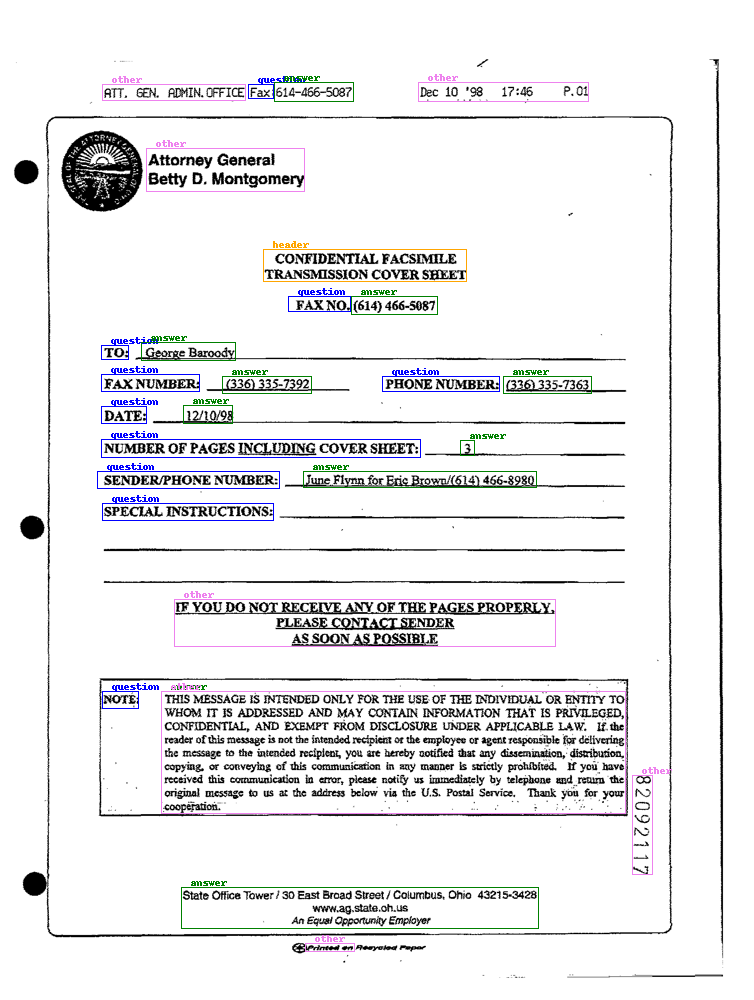

In [ ]:
from PIL import ImageDraw, ImageFont

draw = ImageDraw.Draw(image)

font = ImageFont.load_default()

def iob_to_label(label):
    label = label[2:]
    if not label:
      return 'other'
    return label

label2color = {'question':'blue', 'answer':'green', 'header':'orange', 'other':'violet'}

for prediction, box in zip(true_predictions, true_boxes):
    predicted_label = iob_to_label(prediction).lower()
    draw.rectangle(box, outline=label2color[predicted_label])
    draw.text((box[0] + 10, box[1] - 10), text=predicted_label, fill=label2color[predicted_label], font=font)

image

Compare this to the ground truth:

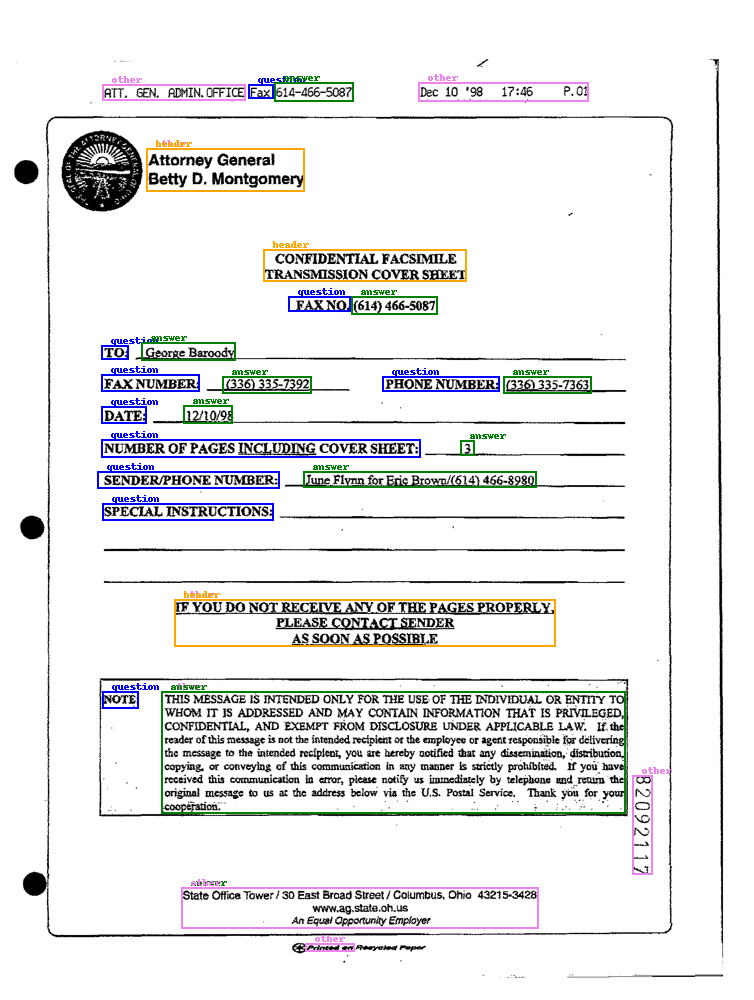

In [ ]:
image = example["image"]
image = image.convert("RGB")

draw = ImageDraw.Draw(image)

for word, box, label in zip(example['tokens'], example['bboxes'], example['ner_tags']):
  actual_label = iob_to_label(id2label[label]).lower()
  box = unnormalize_box(box, width, height)
  draw.rectangle(box, outline=label2color[actual_label], width=2)
  draw.text((box[0] + 10, box[1] - 10), actual_label, fill=label2color[actual_label], font=font)

image

## Note: inference when you don't have labels

The code above used the `labels` to determine which tokens were at the start of a particular word or not. Of course, at inference time, you don't have access to any labels. In that case, you can leverage the `offset_mapping` returned by the tokenizer. I do have a notebook for that (for LayoutLMv2, but it's equivalent for LayoutLMv3) [here](https://github.com/NielsRogge/Transformers-Tutorials/blob/master/LayoutLMv2/FUNSD/True_inference_with_LayoutLMv2ForTokenClassification_%2B_Gradio_demo.ipynb).